In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [2]:
conn = sqlite3.connect('final.db')
cur = conn.cursor()

In [3]:

def fetch_table_names(cur: sqlite3.Cursor) -> [str]:
    '''
    Retrieves all tables in the database
    '''
    
    cur.execute('SELECT name FROM sqlite_master WHERE type = \'table\';')
    return [x[0] for x in cur.fetchall()]

def fetch_column_names(cur: sqlite3.Cursor, table: str) -> [str]:
    '''
    Retrieves all columns in a table
    '''
    
    cur.execute('PRAGMA table_info(' + table + ');')
    return [x[1] for x in cur.fetchall()]

def fetch_col_values(cur: sqlite3.Cursor, table: str, col: str) -> []:
    '''
    Returns all values for a specific column
    '''
    
    cur.execute('SELECT ' + col + ' FROM ' + table + ';')
    return [x[0] for x in cur.fetchall()]

In [4]:
fetch_table_names(cur)

['SCHOOL_TRAIN', 'SCHOOL_TEST', 'POKEMON_TRAIN', 'POKEMON_TEST']

In [5]:
cols = fetch_column_names(cur, 'POKEMON_TRAIN')
testcols = fetch_column_names(cur, 'POKEMON_TEST')
cols

['rowid',
 'unique_id',
 'types',
 'abilities',
 'base_happiness',
 'height_m',
 'weight_kg',
 'poke_stats',
 'is_legendary']

In [6]:
DF = pd.DataFrame()
for x in cols:
    DF = pd.concat([DF, pd.DataFrame(fetch_col_values(cur, 'POKEMON_TRAIN', x))], axis = 1)
DF.columns = cols

testDF = pd.DataFrame()
for x in testcols:
    testDF = pd.concat([testDF, pd.DataFrame(fetch_col_values(cur, 'POKEMON_TEST', x))], axis = 1)
testDF.columns = testcols

Y = DF['is_legendary']
tempDF = DF.drop('is_legendary', axis = 1)

In [7]:
print(tempDF.shape)
tempDF.head()

(520, 8)


,rowid,unique_id,types,abilities,base_happiness,height_m,weight_kg,poke_stats
0,1,665,"fighting, nan","['Guts', 'Sheer Force', 'Iron Fist']",70.0,0.6,12.5,"nan, 80.0, 55.0, 25.0, 35.0, 35.0"
1,2,288,"dragon, nan","['Bulletproof', 'Soundproof', 'Overcoat']",70.0,0.6,29.7,"nan, nan, 65.0, 45.0, 45.0, 45.0"
2,3,349,"poison, fire","['Corrosion', 'Oblivious']",70.0,1.2,22.2,"nan, 64.0, 60.0, 111.0, 60.0, 117.0"
3,4,260,"ground, nan","['Rock Head', 'Lightningrod', 'Battle Armor']",70.0,0.4,6.5,"nan, 50.0, 95.0, 40.0, 50.0, 35.0"
4,5,536,"water, nan","['Torrent', 'Sheer Force']",70.0,0.6,9.5,"nan, 65.0, 64.0, 44.0, 48.0, 43.0"


# rowid(1-520) = training set <br>
# rowid(521 - 801) = testing set

In [8]:
print(testDF.shape)

#setting rowid to keep track of which entires are from the testing set
testDF['rowid'] = range(521, 802)

(281, 8)


In [9]:
totalDF = pd.concat([tempDF, testDF], axis = 0)
totalDF = totalDF.set_index(totalDF['rowid']-1)

In [10]:
totalDF

,rowid,unique_id,types,abilities,base_happiness,height_m,weight_kg,poke_stats
rowid,,,,,,,,
0,1,665,"fighting, nan","['Guts', 'Sheer Force', 'Iron Fist']",70.0,0.6,12.5,"nan, 80.0, 55.0, 25.0, 35.0, 35.0"
1,2,288,"dragon, nan","['Bulletproof', 'Soundproof', 'Overcoat']",70.0,0.6,29.7,"nan, nan, 65.0, 45.0, 45.0, 45.0"
2,3,349,"poison, fire","['Corrosion', 'Oblivious']",70.0,1.2,22.2,"nan, 64.0, 60.0, 111.0, 60.0, 117.0"
3,4,260,"ground, nan","['Rock Head', 'Lightningrod', 'Battle Armor']",70.0,0.4,6.5,"nan, 50.0, 95.0, 40.0, 50.0, 35.0"
4,5,536,"water, nan","['Torrent', 'Sheer Force']",70.0,0.6,9.5,"nan, 65.0, 64.0, 44.0, 48.0, 43.0"
5,6,293,"dragon, fire",['Turboblaze'],0.0,3.2,330.0,"nan, 120.0, 100.0, 150.0, 120.0, 90.0"
6,7,181,"ground, dragon",['Levitate'],70.0,1.1,15.3,"nan, 70.0, 50.0, 50.0, 50.0, 70.0"
7,8,554,"poison, ground","['Poison Point', 'Rivalry', 'Sheer Force']",70.0,1.3,60.0,"nan, 92.0, 87.0, 75.0, 85.0, 76.0"
8,9,507,"bug, electric",['Battery'],70.0,0.5,10.5,"nan, 82.0, 95.0, 55.0, 75.0, 36.0"


## Splitting types into type1 and type2

In [11]:
totalDF[['type1', 'type2']]= totalDF.types.str.split(", ", expand = True)
totalDF = totalDF.drop('types', axis = 1)
totalDF.head()

,rowid,unique_id,abilities,base_happiness,height_m,weight_kg,poke_stats,type1,type2
rowid,,,,,,,,,
0,1,665,"['Guts', 'Sheer Force', 'Iron Fist']",70.0,0.6,12.5,"nan, 80.0, 55.0, 25.0, 35.0, 35.0",fighting,nan
1,2,288,"['Bulletproof', 'Soundproof', 'Overcoat']",70.0,0.6,29.7,"nan, nan, 65.0, 45.0, 45.0, 45.0",dragon,nan
2,3,349,"['Corrosion', 'Oblivious']",70.0,1.2,22.2,"nan, 64.0, 60.0, 111.0, 60.0, 117.0",poison,fire
3,4,260,"['Rock Head', 'Lightningrod', 'Battle Armor']",70.0,0.4,6.5,"nan, 50.0, 95.0, 40.0, 50.0, 35.0",ground,nan
4,5,536,"['Torrent', 'Sheer Force']",70.0,0.6,9.5,"nan, 65.0, 64.0, 44.0, 48.0, 43.0",water,nan


## Splitting poke_stats into individual columns and dropping original poke_stats column

In [12]:
totalDF[['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']] = totalDF.poke_stats.str.split(',', expand = True)

In [13]:
totalDF = totalDF.drop('poke_stats', axis = 1)

In [14]:
totalDF.head()

,rowid,unique_id,abilities,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed
rowid,,,,,,,,,,,,,,
0,1,665,"['Guts', 'Sheer Force', 'Iron Fist']",70.0,0.6,12.5,fighting,nan,nan,80.0,55.0,25.0,35.0,35.0
1,2,288,"['Bulletproof', 'Soundproof', 'Overcoat']",70.0,0.6,29.7,dragon,nan,nan,nan,65.0,45.0,45.0,45.0
2,3,349,"['Corrosion', 'Oblivious']",70.0,1.2,22.2,poison,fire,nan,64.0,60.0,111.0,60.0,117.0
3,4,260,"['Rock Head', 'Lightningrod', 'Battle Armor']",70.0,0.4,6.5,ground,nan,nan,50.0,95.0,40.0,50.0,35.0
4,5,536,"['Torrent', 'Sheer Force']",70.0,0.6,9.5,water,nan,nan,65.0,64.0,44.0,48.0,43.0


## splitting abilities into individual columns and dropping original abilities column

In [15]:
moves = []
for x in totalDF['abilities']:
    moves.append(x)

In [16]:
for x in range(len(moves)):
    moves[x] = moves[x].replace('\'', '')
    moves[x] = moves[x].replace('[', '')
    moves[x] = moves[x].replace(']', '')

In [17]:
totalDF['abilities'] = pd.DataFrame(moves)

In [18]:
abilities = pd.DataFrame(totalDF["abilities"])
moves = []
for x in np.array(abilities["abilities"]):
    tokens = x.split(', ')
    moves.append(tokens)
moves = pd.DataFrame(moves, columns = ['ability1', 'ability2', 'ability3', 'ability4', 'ability5', 'ability6'])
totalDF = pd.concat([totalDF, moves], axis = 1)
totalDF = totalDF.drop('abilities', axis = 1)

In [19]:
totalDF[:10]

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
0,1,665,70.0,0.6,12.5,fighting,nan,nan,80.0,55.0,25.0,35.0,35.0,Guts,Sheer Force,Iron Fist,None,None,None
1,2,288,70.0,0.6,29.7,dragon,nan,nan,nan,65.0,45.0,45.0,45.0,Bulletproof,Soundproof,Overcoat,None,None,None
2,3,349,70.0,1.2,22.2,poison,fire,nan,64.0,60.0,111.0,60.0,117.0,Corrosion,Oblivious,None,None,None,None
3,4,260,70.0,0.4,6.5,ground,nan,nan,50.0,95.0,40.0,50.0,35.0,Rock Head,Lightningrod,Battle Armor,None,None,None
4,5,536,70.0,0.6,9.5,water,nan,nan,65.0,64.0,44.0,48.0,43.0,Torrent,Sheer Force,None,None,None,None
5,6,293,0.0,3.2,330.0,dragon,fire,nan,120.0,100.0,150.0,120.0,90.0,Turboblaze,None,None,None,None,None
6,7,181,70.0,1.1,15.3,ground,dragon,nan,70.0,50.0,50.0,50.0,70.0,Levitate,None,None,None,None,None
7,8,554,70.0,1.3,60.0,poison,ground,nan,92.0,87.0,75.0,85.0,76.0,Poison Point,Rivalry,Sheer Force,None,None,None
8,9,507,70.0,0.5,10.5,bug,electric,nan,82.0,95.0,55.0,75.0,36.0,Battery,None,None,None,None,None
9,10,140,0.0,1.2,55.5,rock,poison,109,53.0,47.0,127.0,131.0,103.0,Beast Boost,None,None,None,None,None


## Replacing NaN in type2 with 'None'

In [20]:
totalDF['type2'] = [None if x == 'nan' else x for x in totalDF['type2']]

## Replacing 'nan' with '0' in stat columns

In [21]:
totalDF['HP'] = [None if x == 'nan' else x for x in totalDF['HP']]
# totalDF['Attack'] = ['0' if x == 'nan' else x for x in totalDF['Attack']]
# totalDF['Defense'] = ['0' if x == 'nan' else x for x in totalDF['Defense']]
# totalDF['Sp_Atk'] = ['0' if x == 'nan' else x for x in totalDF['Sp_Atk']]
# totalDF['Sp_Def'] = ['0' if x == 'nan' else x for x in totalDF['Sp_Def']]
# totalDF['Speed'] = ['0' if x == 'nan' else x for x in totalDF['Speed']]

## Dealing with 'michael was here'

In [22]:
for x in totalDF:
    print(x, ': ', len(totalDF[totalDF[x]=='michael was here']))

rowid :  0
unique_id :  0
base_happiness :  1
height_m :  0
weight_kg :  0
type1 :  0
type2 :  0
HP :  0
Attack :  0
Defense :  0
Sp_Atk :  0
Sp_Def :  0
Speed :  0
ability1 :  0
ability2 :  0
ability3 :  0
ability4 :  0
ability5 :  0
ability6 :  0


C:\Users\M\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [23]:
totalDF[totalDF['base_happiness']=='michael was here']['base_happiness']

619    michael was here
Name: base_happiness, dtype: object

In [24]:
totalDF.loc[619,'base_happiness'] = '70.0'

In [25]:
totalDF[totalDF['base_happiness']=='michael was here']

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6


In [26]:
totalDF[totalDF['base_happiness'].isnull()]

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
36,37,71,None,None,None,ground,ice,None,75.0,90.0,10.0,35.0,40.0,Sand Veil,Sand Rush,Snow Cloak,Slush Rush,None,None
49,50,738,None,0.7,11.5,bug,None,None,35.0,55.0,25.0,nan,15.0,Shed Skin,None,None,None,None,None
61,62,66,None,1.8,175.0,ice,None,None,nan,nan,100.0,200.0,50.0,Clear Body,Ice Body,None,None,None,None
70,71,757,None,0.3,0.6,grass,fairy,None,27.0,60.0,37.0,nan,66.0,Prankster,Infiltrator,Chlorophyll,None,None,None
92,93,605,None,0.8,3.0,grass,flying,None,nan,70.0,55.0,95.0,110.0,Chlorophyll,Leaf Guard,Infiltrator,None,None,None
97,98,64,None,0.6,16.3,normal,None,None,51.0,23.0,51.0,nan,28.0,Soundproof,Rattled,None,None,None,None
101,102,42,None,3.8,199.0,fire,flying,106,nan,90.0,110.0,nan,90.0,Pressure,Regenerator,None,None,None,None
104,105,592,None,0.8,21.5,fighting,flying,None,92.0,75.0,74.0,63.0,118.0,Limber,Unburden,Mold Breaker,None,None,None
116,117,207,None,0.9,19.5,psychic,None,None,20.0,15.0,105.0,55.0,90.0,Synchronize,Inner Focus,Magic Guard,None,None,None
131,132,405,None,1.8,85.2,normal,flying,None,110.0,70.0,60.0,60.0,110.0,Run Away,Early Bird,Tangled Feet,None,None,None


## Dealing with None and empty spaces in height_m column

In [27]:
totalDF['height_m'].fillna('0', inplace = True)

In [28]:
totalDF[totalDF['height_m'].isnull()]

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6


In [29]:
np.unique(totalDF['height_m'])

array([' ', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       '0.9', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7',
       '1.8', '1.9', '14.5', '2.0', '2.1', '2.2', '2.3', '2.4', '2.5',
       '2.6', '2.7', '2.8', '2.9', '3.0', '3.2', '3.3', '3.4', '3.5',
       '3.7', '3.8', '3.9', '4.0', '4.2', '4.5', '5.0', '5.2', '5.4',
       '5.5', '5.8', '6.2', '6.5', '7.0', '8.8', '9.2'], dtype=object)

In [30]:
totalDF[totalDF['height_m']==' ']

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
647,648,221,70.0,,71.0,ghost,grass,None,110.0,76.0,65.0,82.0,56.0,Natural Cure,Frisk,Harvest,None,None,None


In [31]:
totalDF.loc[647,'height_m'] = '0.0'

In [32]:
totalDF[totalDF['height_m']== ' ']

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6


In [33]:
totalDF[totalDF['base_happiness'].isnull()]

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
36,37,71,None,0,None,ground,ice,None,75.0,90.0,10.0,35.0,40.0,Sand Veil,Sand Rush,Snow Cloak,Slush Rush,None,None
49,50,738,None,0.7,11.5,bug,None,None,35.0,55.0,25.0,nan,15.0,Shed Skin,None,None,None,None,None
61,62,66,None,1.8,175.0,ice,None,None,nan,nan,100.0,200.0,50.0,Clear Body,Ice Body,None,None,None,None
70,71,757,None,0.3,0.6,grass,fairy,None,27.0,60.0,37.0,nan,66.0,Prankster,Infiltrator,Chlorophyll,None,None,None
92,93,605,None,0.8,3.0,grass,flying,None,nan,70.0,55.0,95.0,110.0,Chlorophyll,Leaf Guard,Infiltrator,None,None,None
97,98,64,None,0.6,16.3,normal,None,None,51.0,23.0,51.0,nan,28.0,Soundproof,Rattled,None,None,None,None
101,102,42,None,3.8,199.0,fire,flying,106,nan,90.0,110.0,nan,90.0,Pressure,Regenerator,None,None,None,None
104,105,592,None,0.8,21.5,fighting,flying,None,92.0,75.0,74.0,63.0,118.0,Limber,Unburden,Mold Breaker,None,None,None
116,117,207,None,0.9,19.5,psychic,None,None,20.0,15.0,105.0,55.0,90.0,Synchronize,Inner Focus,Magic Guard,None,None,None
131,132,405,None,1.8,85.2,normal,flying,None,110.0,70.0,60.0,60.0,110.0,Run Away,Early Bird,Tangled Feet,None,None,None


## None values and non-numeric strings in weight_kg

In [34]:
totalDF['weight_kg'].fillna('0', inplace = True)

In [35]:
np.unique(totalDF['weight_kg'])

array([' ', '0', '0.1', '0.2', '0.3', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1.0', '1.1', '1.2', '1.4', '1.5', '1.7', '1.8', '1.9', '10.0',
       '10.1', '10.2', '10.3', '10.4', '10.5', '10.8', '10.9', '100.0',
       '100.5', '102.0', '102.5', '102.6', '105.0', '105.5', '106.6',
       '107.3', '108.0', '11.0', '11.2', '11.5', '11.6', '11.8', '110.0',
       '110.5', '115.0', '118.0', '12.0', '12.4', '12.5', '120.0',
       '120.5', '122.0', '125.8', '128.6', '13.0', '13.3', '13.5', '13.6',
       '130.0', '130.5', '132.5', '135.0', '135.5', '136.0', '138.6',
       '139.0', '14.0', '14.2', '14.3', '14.5', '14.7', '14.8', '140.0',
       '148.0', '149.5', '15.0', '15.2', '15.3', '15.5', '15.8', '150.0',
       '150.5', '150.6', '152.0', '154.0', '155.0', '16.0', '16.3',
       '16.5', '16.8', '160.0', '162.0', '168.0', '17.0', '17.3', '17.5',
       '17.7', '175.0', '178.0', '18.0', '18.5', '18.6', '18.8', '180.0',
       '185.0', '187.0', '19.0', '19.2', '19.5', '19.6', '19.8', 

In [36]:
totalDF[totalDF['weight_kg']==' ']

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
535,536,74,70.0,0.8,,rock,dragon,None,89.0,77.0,nan,45.0,48.0,Strong Jaw,Sturdy,None,None,None,None
545,546,274,70.0,0,,fire,ice,None,41.0,40.0,50.0,65.0,65.0,Flash Fire,Drought,Snow Cloak,Snow Warning,None,None


In [37]:
totalDF[totalDF['weight_kg']==' ']

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
535,536,74,70.0,0.8,,rock,dragon,None,89.0,77.0,nan,45.0,48.0,Strong Jaw,Sturdy,None,None,None,None
545,546,274,70.0,0,,fire,ice,None,41.0,40.0,50.0,65.0,65.0,Flash Fire,Drought,Snow Cloak,Snow Warning,None,None


In [38]:
totalDF.loc[535,'weight_kg'] = '0.0'
totalDF.loc[545,'weight_kg'] = '0.0'

## Casting numerics from strings to floats

In [39]:
totalDF['unique_id'] = totalDF['unique_id'].astype(int)
totalDF['base_happiness'] = totalDF['base_happiness'].astype(float)
totalDF['height_m'] = totalDF['height_m'].astype(float)
totalDF['weight_kg'] = totalDF['weight_kg'].astype(float)
totalDF['HP'] = totalDF['HP'].astype(float)
totalDF['Attack'] = totalDF['Attack'].astype(float)
totalDF['Defense'] = totalDF['Defense'].astype(float)
totalDF['Sp_Atk'] = totalDF['Sp_Atk'].astype(float)
totalDF['Sp_Def'] = totalDF['Sp_Def'].astype(float)
totalDF['Speed'] = totalDF['Speed'].astype(float)

In [40]:
totalDF

,rowid,unique_id,base_happiness,height_m,weight_kg,type1,type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,ability1,ability2,ability3,ability4,ability5,ability6
0,1,665,70.0,0.6,12.5,fighting,None,NaN,80.0,55.0,25.0,35.0,35.0,Guts,Sheer Force,Iron Fist,None,None,None
1,2,288,70.0,0.6,29.7,dragon,None,NaN,NaN,65.0,45.0,45.0,45.0,Bulletproof,Soundproof,Overcoat,None,None,None
2,3,349,70.0,1.2,22.2,poison,fire,NaN,64.0,60.0,111.0,60.0,117.0,Corrosion,Oblivious,None,None,None,None
3,4,260,70.0,0.4,6.5,ground,None,NaN,50.0,95.0,40.0,50.0,35.0,Rock Head,Lightningrod,Battle Armor,None,None,None
4,5,536,70.0,0.6,9.5,water,None,NaN,65.0,64.0,44.0,48.0,43.0,Torrent,Sheer Force,None,None,None,None
5,6,293,0.0,3.2,330.0,dragon,fire,NaN,120.0,100.0,150.0,120.0,90.0,Turboblaze,None,None,None,None,None
6,7,181,70.0,1.1,15.3,ground,dragon,NaN,70.0,50.0,50.0,50.0,70.0,Levitate,None,None,None,None,None
7,8,554,70.0,1.3,60.0,poison,ground,NaN,92.0,87.0,75.0,85.0,76.0,Poison Point,Rivalry,Sheer Force,None,None,None
8,9,507,70.0,0.5,10.5,bug,electric,NaN,82.0,95.0,55.0,75.0,36.0,Battery,None,None,None,None,None
9,10,140,0.0,1.2,55.5,rock,poison,109.0,53.0,47.0,127.0,131.0,103.0,Beast Boost,None,None,None,None,None


In [41]:
totalDF = pd.get_dummies(totalDF, 
                         columns = ['base_happiness', 'type1', 'type2', 'ability1', 
                                    'ability2', 'ability3', 'ability4', 'ability5', 'ability6'],
                        dummy_na = True)
totalDF

,rowid,unique_id,height_m,weight_kg,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,ability5_Vital Spirit,ability5_nan,ability6_Galvanize,ability6_No Guard,ability6_Power of Alchemy,ability6_Rattled,ability6_Rock Head,ability6_Sand Force,ability6_Thick Fat,ability6_nan
0,1,665,0.6,12.5,NaN,80.0,55.0,25.0,35.0,35.0,...,0,1,0,0,0,0,0,0,0,1
1,2,288,0.6,29.7,NaN,NaN,65.0,45.0,45.0,45.0,...,0,1,0,0,0,0,0,0,0,1
2,3,349,1.2,22.2,NaN,64.0,60.0,111.0,60.0,117.0,...,0,1,0,0,0,0,0,0,0,1
3,4,260,0.4,6.5,NaN,50.0,95.0,40.0,50.0,35.0,...,0,1,0,0,0,0,0,0,0,1
4,5,536,0.6,9.5,NaN,65.0,64.0,44.0,48.0,43.0,...,0,1,0,0,0,0,0,0,0,1
5,6,293,3.2,330.0,NaN,120.0,100.0,150.0,120.0,90.0,...,0,1,0,0,0,0,0,0,0,1
6,7,181,1.1,15.3,NaN,70.0,50.0,50.0,50.0,70.0,...,0,1,0,0,0,0,0,0,0,1
7,8,554,1.3,60.0,NaN,92.0,87.0,75.0,85.0,76.0,...,0,1,0,0,0,0,0,0,0,1
8,9,507,0.5,10.5,NaN,82.0,95.0,55.0,75.0,36.0,...,0,1,0,0,0,0,0,0,0,1
9,10,140,1.2,55.5,109.0,53.0,47.0,127.0,131.0,103.0,...,0,1,0,0,0,0,0,0,0,1


## Filling NaN in stat columns with 0

In [42]:
#totalDF[['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']].fillna(0, inplace = True)
totalDF['HP'].fillna(0, inplace = True)
totalDF['Attack'].fillna(0, inplace = True)
totalDF['Defense'].fillna(0, inplace = True)
totalDF['Sp_Atk'].fillna(0, inplace = True)
totalDF['Sp_Def'].fillna(0, inplace = True)
totalDF['Speed'].fillna(0, inplace = True)

In [43]:
trainDF = totalDF[totalDF['rowid']<521]
testDF = totalDF[totalDF['rowid']>521]
trainDF = pd.concat([trainDF, Y], axis = 1)

In [44]:
#total = pd.DataFrame(trainDF['HP']+trainDF['Attack']+trainDF['Defense']+trainDF['Sp_Atk']+trainDF['Sp_Def']+trainDF['Speed'],
#                    columns = ['Sum_Stats'])

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(trainDF, Y)

In [46]:
RFC = RandomForestClassifier()

In [47]:

RFC.fit(xtrain, ytrain)
YP = RFC.predict(xtest)
accuracy_score(YP, np.array(ytest))

C:\Users\M\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9538461538461539

In [48]:
YP.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [49]:
np.array(ytest).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [50]:
precision_score(np.array(ytest).astype(int), np.array(YP).astype(int), average = 'weighted')

0.9560794044665013

## Graphing the data

In [57]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(np.array(ytest).astype(int), np.array(YP).astype(int))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.55


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

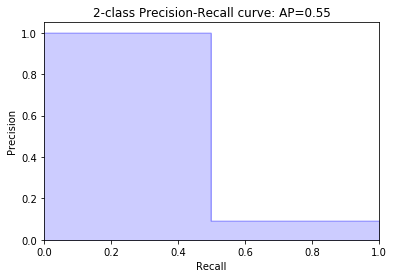

In [56]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(np.array(ytest).astype(int), np.array(YP).astype(int))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))